# Import Dependencies

In [36]:
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
import numpy as np
import itertools
from copy import deepcopy

# Define the Matrix Class

## Class Definition 

...for a matrix representation of the CSS code. Rows are qubits and columns are stabilizers or logical operators

In [37]:
from dataclasses import dataclass, field
import numpy as np

@dataclass
class CodeMatrix:
    n_qubits: int
    data: np.ndarray = field(init=False)
    col_labels: list = field(default_factory=list)
    history: list = field(default_factory=list)

    def __post_init__(self):
        self.data = np.zeros((self.n_qubits, 0), dtype=np.uint8)
        self.logical_added = False
        self.logical_col_ids = []

    def add_column(self, qubits, label=None):
        if self.logical_added: raise Exception("Cannot add a stabilizer column AFTER a logical column")
        col = np.zeros((self.n_qubits, 1), dtype=np.uint8)
        for q in qubits:
            col[q, 0] = 1
        self.data = np.hstack([self.data, col])
        self.col_labels.append(label or f"C{self.data.shape[1]-1}")
        self.history.append(("add_col", label, qubits))

    def add_logical(self, qubits, label=None):
        self.logical_added = True
        col = np.zeros((self.n_qubits, 1), dtype=np.uint8)
        for q in qubits:
            col[q, 0] = 1
        self.data = np.hstack([self.data, col])
        self.col_labels.append(label or f"C{self.data.shape[1]-1}")
        self.history.append(("add_col", label, qubits))
        self.logical_col_ids.append(self.data.shape[1]-1)

    def __repr__(self):
        labels = [lbl or "-" for lbl in self.col_labels]
        return f"CodeMatrix({self.n_qubits}q, cols={labels})\n{self.data}"

    def __str__(self):
        if self.data.size == 0:
            return f"<Empty CodeMatrix with {self.n_qubits} qubits>"
        display = np.where(self.data == 0, '-', '1')
        header = "     " + "  ".join(f"{lbl:>3}" for lbl in self.col_labels)
        # header = ""
        rows = []
        for i, row in enumerate(display):
            row_str = f"q{i:>2} | " + "  ".join(row)
            rows.append(row_str)
        return f"CodeMatrix ({self.n_qubits} qubits)\n" + header + "\n" + "\n".join(rows)

    def row_op(self, source, target):
        """
        Perform a row operation (source -> target), i.e. add control row to target row mod 2.
        This corresponds to a CNOT with control qubit = control, target qubit = target.
        """
        self.data[target] ^= self.data[source]
        self.history.append(("row_op", source, target))

    def col_op(self, source, target):
        """
        Perform a column operation (source -> target), i.e. add source column to target column mod 2.
        This redefines stabilizers/logicals without changing physical gates.
        """
        self.data[:, target] ^= self.data[:, source]
        self.history.append(("col_op", source, target))

    def copy(self):
        return deepcopy(self)

## [7, 1, 3] Color Code Matrix

In [38]:
code = CodeMatrix(7) # Create the [7, 1, 3] code matrix object

code.add_column([0, 1, 2, 3])   # S0 = [Z0, Z1, Z2, Z3]
code.add_column([1, 2, 4, 5])   # S1 = [Z0, Z1, Z2, Z3] 
code.add_column([2, 3, 4, 6])   # S2 = [Z0, Z1, Z2, Z3] 
code.add_logical([0, 1, 5])      # L0 = [Z0, Z1, Z5] 

print(code)

print("Steps from the paper: \n")

final_code = code.copy()
final_code.row_op(0, 1)
final_code.row_op(3, 2)
final_code.row_op(5, 4)
final_code.row_op(0, 3)
final_code.row_op(2, 5)
final_code.row_op(4, 6)
final_code.row_op(2, 1)
final_code.row_op(4, 3)
final_code.row_op(6, 5)
final_code.col_op(0, 3)
final_code.col_op(2, 3)
print(final_code)


CodeMatrix (7 qubits)
      C0   C1   C2   C3
q 0 | 1  -  -  1
q 1 | 1  1  -  1
q 2 | 1  1  1  -
q 3 | 1  -  1  -
q 4 | -  1  1  -
q 5 | -  1  -  1
q 6 | -  -  1  -
Steps from the paper: 

CodeMatrix (7 qubits)
      C0   C1   C2   C3
q 0 | 1  -  -  -
q 1 | -  -  -  -
q 2 | -  1  -  -
q 3 | -  -  -  -
q 4 | -  -  1  -
q 5 | -  -  -  -
q 6 | -  -  -  1


# Define the Simplifier Class

## Code Matrix Functions

In [39]:
# Tells you if a list of pairs is disjoint or not
def disjoint(pairs):
    used = set()
    for c, t in pairs:
        if c in used or t in used:
            return False
        used.add(c); used.add(t)
    return True

# Create all possible n // 2 disjoint pairs of qubits
def all_layers(n):
    all_pairs = [(i, j) for i in range(n) for j in range(n) if i != j]
    k = n // 2
    layers = []
    for combo in itertools.combinations(all_pairs, k):
        if disjoint(combo):
            layers.append(combo)
    return layers

def valid_col_ops(M):
    num_cols = M.data.shape[1]
    logical = set(M.logical_col_ids)
    ops = []
    for c in range(num_cols):
        if c in logical:
            continue  # can't use logical as control
        for t in range(num_cols):
            if t != c:
                ops.append((c, t))
    return ops

def col_layers(M, N):
    ops = valid_col_ops(M)
    return list(itertools.product(ops, repeat=N))

## Class Definition

In [76]:
# Empirically discovered pre-weights
h2_avg = 0.429
h2_std = 2.115
h3_avg = -6.0
h3_std = 2.242
h4_avg = -2.571
h4_std = 0.767

h2_wt = 0.8
h3_wt = 0.25
h4_wt = 1.0

class MatrixSimplifier:
    
    def __init__(self, code_matrix):
        self.base_matrix = code_matrix
        self.current_matrix = self.base_matrix.copy()
        self.layer_history = []

    def total_weight(self, M):
        return int(M.data.sum())
    
    def try_row_op(self, layer):
        mm = self.current_matrix.copy()
        for control, target in layer:
            mm.row_op(control, target)
        return mm
    
    def try_col_op(self, layer):
        mm = self.current_matrix.copy()
        for control, target in layer:
            mm.col_op(control, target)
        return mm
    
    def valid_matrix(self, M):
        logical_cols = M.logical_col_ids

        for col in logical_cols:
            col_vec = M.data[:, col]
            wt = int(col_vec.sum())
            if wt != 1:    # must be exactly one 1
                return False

        return True
    
    # For all heuristic scoring functions, lower score is better

    def final_weight(self, layer):
        M_after = self.try_row_op(layer)
        return self.total_weight(M_after)

    ### H2: total ones reduction
    def score_H2(self, layer):
        M_before = self.current_matrix
        M_after = self.try_row_op(layer)
        before = int(M_before.data.sum())
        after  = int(M_after.data.sum())
        score = after - before
        return (score - h2_avg) / h2_std

    ### H3: similarity gain (positive = better)
    def hamming_similarity_gain(self, M, control, target):
        tgt = M.data[target]
        ctrl = M.data[control]
        new_tgt = tgt ^ ctrl
        gain = 0
        for i in range(M.n_qubits):
            if i == target: continue
            current = np.count_nonzero(tgt != M.data[i])
            new = np.count_nonzero(new_tgt != M.data[i])
            gain += (current - new)
        return gain

    def score_H3(self, layer):
        M = self.current_matrix
        gain = sum(self.hamming_similarity_gain(M, c, t) for c,t in layer)
        score = -gain
        return (score - h3_avg) / h3_std

    ### H4: heavy-column gain (positive = better)
    def heavy_col_gain(self, M, control, target):
        weights = M.data.sum(axis=0)
        heavy = weights >= np.percentile(weights, 75)

        tgt_before = M.data[target]
        tgt_after  = tgt_before ^ M.data[control]

        removed = np.sum((tgt_before == 1) & (tgt_after == 0) & heavy)
        return removed

    def score_H4(self, layer):
        M = self.current_matrix
        gain = sum(self.heavy_col_gain(M, c, t) for c,t in layer)
        score = -gain  # negative = good
        return (score - h4_avg) / h4_std
    
    def total_score(self, layer):
        return (
            h2_wt * self.score_H2(layer) +
            h3_wt * self.score_H3(layer) +
            h4_wt * self.score_H4(layer) 
            )
    
    def debug_score(self, layer):
        h2 = self.score_H2(layer)
        h3 = self.score_H3(layer)
        h4 = self.score_H4(layer)
        total = 1.0*h2 + 0.25*h3 + 0.5*h4
        print(f"H2={h2:.2f}, H3={h3:.2f}, H4={h4:.2f}, total={total:.2f}")

    #################

## Enumerate Search Heuristics

1. Choose row operations in layers, in which we pick the best n/2 disjoint
pairs of rows for row operations before reusing rows in the next layer.
This maximizes circuit parallelism because each row operation will
become a CNOT.

2. Every row operation ideally reduces (or sometimes maintains) the
total number of 1 entries.

3. A row operation is preferred if it leaves the updated row more similar
(by Hamming distance) to another row. This enables a future row
operation to be more effective.

4. Prioritize row operations to remove 1 entries from high-weight columns (high relative numbers of 1 entries). If certain columns are
very high-weight near row-reduction completion, backtrack and
prioritize them sooner.

5. While backtracking to try new choices, prioritize minimizing the
number of operation layers over the number of operations.

6. Column operations do not need to be optimal because they do not
affect the circuit; they only redefine the stabilizer basis.

# Study the Heuristic Weights

## Balance the Initial Weights

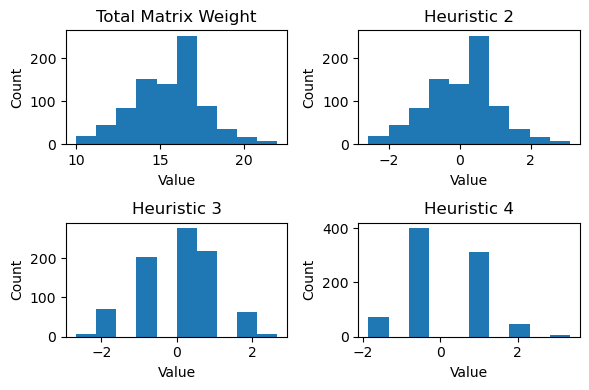

In [79]:
smp = MatrixSimplifier(code)

pairs = all_layers(code.n_qubits)
total_weight = []
h2 = []
h3 = []
h4 = []

for layer in pairs:
    total_weight.append(smp.final_weight(layer))
    h2.append(smp.score_H2(layer))
    h3.append(smp.score_H3(layer))
    h4.append(smp.score_H4(layer))

h2 = np.array(h2)
h3 = np.array(h3)
h4 = np.array(h4)

fig, axes = plt.subplots(2, 2, figsize=(6, 4))

axes[0, 0].hist(total_weight, bins=10)
axes[0, 0].set_title("Total Matrix Weight")

axes[0, 1].hist(h2, bins=10)
axes[0, 1].set_title("Heuristic 2")

axes[1, 0].hist(h3, bins=10)
axes[1, 0].set_title("Heuristic 3")

axes[1, 1].hist(h4, bins=10)
axes[1, 1].set_title("Heuristic 4")

for ax in axes.flat:
    ax.set_xlabel("Value")
    ax.set_ylabel("Count")

fig.tight_layout()
plt.show()

## Study All Possible Layers

In [80]:
smp = MatrixSimplifier(code)

pairs = all_layers(code.n_qubits)
scores = []
results = []

for layer in pairs:
    score = smp.total_score(layer)
    scores.append(score)
    results.append((score, layer))

results = np.array(results, dtype=object)

print(f"Average Score: {np.average(scores)}")

key = ((0, 1), (3, 2), (5, 4))
mask = np.array([k == key for _, k in results])
score = results[mask][0][0]

print(f"\nFor My Best Layer: {results[np.argmin(scores)][1]}")
print(f"\tH2: {smp.score_H2(results[np.argmin(scores)][1])}")
print(f"\tH3: {smp.score_H3(results[np.argmin(scores)][1])}")
print(f"\tH4: {smp.score_H4(results[np.argmin(scores)][1])}")
print(f"\tScore: {smp.total_score(results[np.argmin(scores)][1])}")

print(f"\nFor Their Best Layer: {key}")
print(f"\tH2: {smp.score_H2(key)}")
print(f"\tH3: {smp.score_H3(key)}")
print(f"\tH4: {smp.score_H4(key)}")
print(f"\tScore: {smp.total_score(key)}")

Average Score: -0.0007208706667773596

For My Best Layer: ((0, 1), (3, 2), (6, 4))
	H2: -2.566903073286052
	H3: 1.784121320249777
	H4: -1.8631029986962189
	Score: -3.4705951272626163

For Their Best Layer: ((0, 1), (3, 2), (5, 4))
	H2: -2.0940898345153665
	H3: 1.784121320249777
	H4: -1.8631029986962189
	Score: -3.0923445362460678


# Full Simplification with Backtracking

## Higher Level Functions

In [102]:
# Return a ranked list from min to max scores of all possible get layers
def rank_gate_layers(simplifier):
    pairs = all_layers(simplifier.base_matrix.n_qubits)
    scores = []
    results = []

    for layer in pairs:
        score = smp.total_score(layer)
        scores.append(score)
        results.append((score, layer))

    results = np.array(results, dtype=object)
    return sorted(results, key=lambda x: x[0])

# Checks to see if any permutation of m column operations can finish your circuit and return them
def search_col_ops(simplifier):

    current = simplifier.current_matrix # Grab the current state of the simplifier
    num_cols = current.data.shape[1]    # Get the number of columns in the matrix

    valid_col_ops = []
    
    for m in range(num_cols + 1):           # Try some number of column operations up to m = cols+1
        candidates = col_layers(current, m) # Generate all possible m-length sets of column operations
    
        for layer in candidates:            # Try out each possible column op layer
            test_matrix = current.copy()    # Create a temporary matrix to test this with
    
            for control, target in layer:   # Apply the column operation
                test_matrix.col_op(control, target)
    
            if simplifier.valid_matrix(test_matrix): # Test the result to see if we can be done
                valid_col_ops.append(layer)

    print(f"Length: {len(valid_col_ops)}")
    if (len(layer) == 0): # We were not able to find any set of column operations to finish the matrix
        return None
    else:
        return valid_col_ops
        # results = []
        # for layer in valid_col_ops:
        #     results.append((smp.final_weight(layer), layer))
        #     return sorted(results, key=lambda x: x[0])[0]

In [103]:
final_code = code.copy()

final_code.row_op(0, 1)
final_code.row_op(3, 2)
final_code.row_op(5, 4)
final_code.row_op(0, 3)
final_code.row_op(2, 5)
final_code.row_op(4, 6)
final_code.row_op(2, 1)
final_code.row_op(4, 3)
final_code.row_op(6, 5)

# final_code.col_op(0, 2)
# final_code.col_op(2, 3)

smp = MatrixSimplifier(final_code)

print(search_col_ops(smp))

print(smp.valid_matrix(final_code))

print(final_code)

Length: 636
[((0, 2), (2, 3)), ((0, 3), (2, 3)), ((2, 0), (0, 3)), ((2, 3), (0, 3)), ((0, 1), (0, 2), (2, 3)), ((0, 1), (0, 3), (2, 3)), ((0, 1), (2, 0), (0, 3)), ((0, 1), (2, 3), (0, 3)), ((0, 2), (0, 1), (2, 3)), ((0, 2), (1, 0), (2, 3)), ((0, 2), (2, 0), (2, 3)), ((0, 2), (2, 1), (2, 3)), ((0, 2), (2, 3), (0, 1)), ((0, 2), (2, 3), (0, 2)), ((0, 2), (2, 3), (1, 0)), ((0, 2), (2, 3), (1, 2)), ((0, 2), (2, 3), (2, 0)), ((0, 2), (2, 3), (2, 1)), ((0, 3), (0, 1), (2, 3)), ((0, 3), (1, 0), (2, 3)), ((0, 3), (2, 0), (2, 3)), ((0, 3), (2, 1), (2, 3)), ((0, 3), (2, 3), (0, 1)), ((0, 3), (2, 3), (0, 2)), ((0, 3), (2, 3), (1, 0)), ((0, 3), (2, 3), (1, 2)), ((0, 3), (2, 3), (2, 0)), ((0, 3), (2, 3), (2, 1)), ((2, 0), (0, 1), (0, 3)), ((2, 0), (0, 2), (0, 3)), ((2, 0), (0, 3), (0, 1)), ((2, 0), (0, 3), (0, 2)), ((2, 0), (0, 3), (1, 0)), ((2, 0), (0, 3), (1, 2)), ((2, 0), (0, 3), (2, 0)), ((2, 0), (0, 3), (2, 1)), ((2, 0), (1, 2), (0, 3)), ((2, 0), (2, 1), (0, 3)), ((2, 1), (0, 2), (2, 3)), ((2, 